Theory Questions:

1) Why is the KL Divergence term important in the VAE loss function?

The KL divergence in a Variational Autoencoder (VAE) is like a quality control mechanism. It ensures that the model’s internal representation of data is both efficient and meaningful. By encouraging the model to keep its representations close to a standard format (often a normal distribution), it makes sure the model doesn’t just memorize data but understands it in a way that’s useful for generating new data. This helps the model not only perform well during training but also be good at coming up with new, plausible data points similar to what it has seen before. Essentially, it keeps the model’s imagination in check, making sure it’s creative but still realistic!

2)  How does the reparameterization trick enable backpropagation through the stochas
tic layers of a VAE?

In a Variational Autoencoder (VAE), the reparameterization trick is a smart workaround that lets us train the model using backpropagation, even though it involves randomness. Normally, the random part of VAEs makes it tough to apply backpropagation directly because you can't calculate gradients through random processes.

Here’s what the reparameterization trick does:

    a) Separates the random bit: Instead of sampling a value directly in a way that’s tied to the model’s parameters (which are being learned), it samples from a standard "noise" distribution that doesn't depend on the model. This noise is just random numbers with no connection to the model's trainable bits.

    b) Reconstructs the sample: It then uses this noise to construct the actual sample needed by tweaking it with the model’s outputs (like mean and variance). This way, the randomness is kept separate, and the part that involves the model's parameters can now be differentiated and updated using gradients.

Because of this trick, the randomness doesn’t block the gradient calculations during training. It lets us keep the model trainable with standard methods, while also allowing it to generate diverse and new data by injecting randomness in a controlled way. This is essential for making VAEs practical and effective in generating new, varied data while still learning from the training set.

3) Why does a VAE use a probabilistic latent space instead of a fixed latent space?

A Variational Autoencoder (VAE) using a probabilistic latent space is akin to a skilled artist who not only replicates what they see but also explores potential variations. This probabilistic approach enables the VAE to handle uncertainty, allowing it to adapt to diverse and complex data by considering a spectrum of possibilities rather than a single fixed representation. Consequently, by interpreting data through probabilities, a VAE can generate new and varied outputs that are both reminiscent of familiar data and intriguingly unique. This capability allows VAEs to not just learn from data but to creatively expand upon it, innovating in ways that traditional models might not.

4) What role does KL Divergence play in ensuring a smooth latent space?

The KL Divergence in a Variational Autoencoder (VAE) acts like a regulator, ensuring the model's latent space—the model's internal understanding of data—is smooth and orderly. It does this by penalizing deviations from a predefined notion of how data should be distributed. This not only keeps similar data points close together in the latent space, making it easier for the VAE to interpolate and generate new, coherent samples, but it also ensures that the model's representations remain grounded and consistent, preventing the generation of unrealistic or wildly varied outputs. Essentially, KL Divergence keeps the model's creativity in check, guiding it to produce plausible and diverse outputs.

In [1]:
# Cell 1: Import Libraries and Define Loss Functions

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Loss Function with MSE for Reconstruction and KL Divergence
def improved_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x.view(-1, 3*32*32), x.view(-1, 3*32*32), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


In [2]:
# Cell 2: Define Fully Connected VAE (FC-VAE) and Improved Convolutional VAE (CNN-VAE) Classes

class FC_VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=20):
        super(FC_VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3072)))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Improved_CNN_VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(Improved_CNN_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Output: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # Output: 3 x 32 x 32
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(-1, 128*4*4)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc(z)
        h3 = h3.view(-1, 128, 4, 4)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
# Cell 2: Define Improved Convolutional VAE (CNN-VAE) Class

class Improved_CNN_VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(Improved_CNN_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Output: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # Output: 3 x 32 x 32
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(-1, 128*4*4)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc(z)
        h3 = h3.view(-1, 128, 4, 4)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
# Cell 3: Load Data and Initialize Models

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations and loading
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize models
fc_vae = FC_VAE().to(device)
cnn_vae = Improved_CNN_VAE().to(device)

# Optimizers
optimizer_fc = optim.Adam(fc_vae.parameters(), lr=1e-3)
optimizer_cnn = optim.Adam(cnn_vae.parameters(), lr=1e-3)


In [5]:
# Cell 4: Train the Models

def train(epoch, model, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = improved_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f'Epoch: {epoch} Model: {model.__class__.__name__} Average loss: {total_loss / len(train_loader.dataset):.4f}')

# Training
num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train(epoch, fc_vae, optimizer_fc)
    train(epoch, cnn_vae, optimizer_cnn)


Epoch: 1 Model: FC_VAE Average loss: 120.4769
Epoch: 1 Model: Improved_CNN_VAE Average loss: 92.5322
Epoch: 2 Model: FC_VAE Average loss: 92.1253
Epoch: 2 Model: Improved_CNN_VAE Average loss: 80.2369
Epoch: 3 Model: FC_VAE Average loss: 87.7496
Epoch: 3 Model: Improved_CNN_VAE Average loss: 78.9930
Epoch: 4 Model: FC_VAE Average loss: 85.7919
Epoch: 4 Model: Improved_CNN_VAE Average loss: 78.4230
Epoch: 5 Model: FC_VAE Average loss: 84.4406
Epoch: 5 Model: Improved_CNN_VAE Average loss: 77.9313
Epoch: 6 Model: FC_VAE Average loss: 82.9765
Epoch: 6 Model: Improved_CNN_VAE Average loss: 77.4961
Epoch: 7 Model: FC_VAE Average loss: 82.0395
Epoch: 7 Model: Improved_CNN_VAE Average loss: 77.1272
Epoch: 8 Model: FC_VAE Average loss: 81.3105
Epoch: 8 Model: Improved_CNN_VAE Average loss: 77.1277
Epoch: 9 Model: FC_VAE Average loss: 80.9195
Epoch: 9 Model: Improved_CNN_VAE Average loss: 76.9090
Epoch: 10 Model: FC_VAE Average loss: 80.4223
Epoch: 10 Model: Improved_CNN_VAE Average loss: 76.75

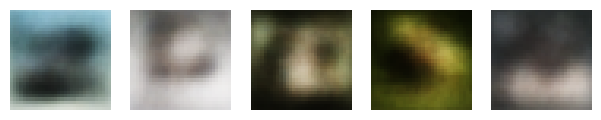

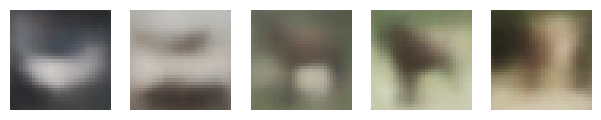

In [6]:
# Cell 5: Generate and Display Images

def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 20).to(device)
        samples = model.decode(z).cpu()
        samples = samples.view(num_images, 3, 32, 32)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 1.5, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].permute(1, 2, 0))
        ax.axis('off')
    plt.show()

generate_images(fc_vae, num_images=5)
generate_images(cnn_vae, num_images=5)


Task 2

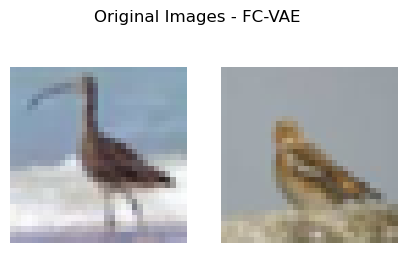

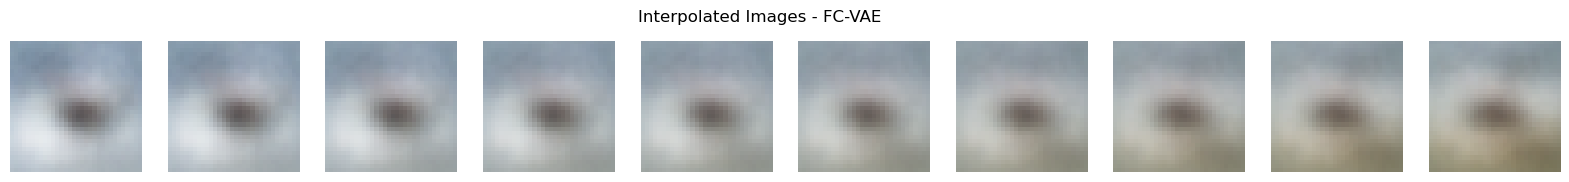

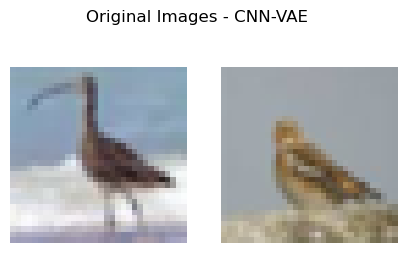

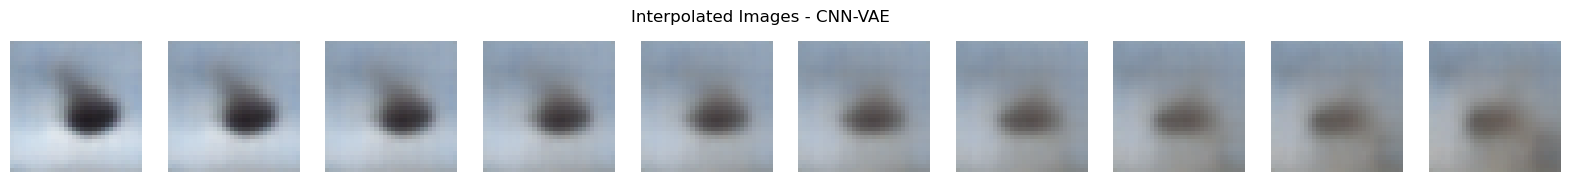

In [7]:
# Cell 6: Updated Interpolation and Visualization for Both VAE Models

def interpolate(model, start_data, end_data, steps=20):
    model.eval()
    with torch.no_grad():
        # Ensure input data is on the correct device
        start_data = start_data.to(device).unsqueeze(0)
        end_data = end_data.to(device).unsqueeze(0)

        # Encode the start and end images to latent space
        start_mu, start_logvar = model.encode(start_data)
        end_mu, end_logvar = model.encode(end_data)
        
        # Reparameterize to get the latent vectors
        z_start = model.reparameterize(start_mu, start_logvar)
        z_end = model.reparameterize(end_mu, end_logvar)
        
        # Linear interpolation of latent vectors
        interpolation_weights = torch.linspace(0, 1, steps).to(device)
        z_interp = (1 - interpolation_weights)[:, None] * z_start + interpolation_weights[:, None] * z_end
        
        # Decode the interpolated latent vectors
        interp_data = model.decode(z_interp).view(-1, 3, 32, 32)  # Ensure correct shape

    return interp_data

def display_interpolation(model, images, title):
    images = images.to(device)

    # Select two images for interpolation
    interp_images = interpolate(model, images[0], images[1], steps=10)
    
    # Visualize the actual images
    fig, axs = plt.subplots(1, 2, figsize=(5, 3))
    axs[0].imshow(images[0].cpu().permute(1, 2, 0))
    axs[1].imshow(images[1].cpu().permute(1, 2, 0))
    for ax in axs:
        ax.axis('off')
    plt.suptitle('Original Images - ' + title)
    plt.show()

    # Visualize the interpolated images
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axs):
        ax.imshow(interp_images[i].cpu().detach().permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle('Interpolated Images - ' + title)
    plt.show()

# Get some images
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Display interpolation for FC-VAE
display_interpolation(fc_vae, images[:2], "FC-VAE")

# Display interpolation for CNN-VAE
display_interpolation(cnn_vae, images[:2], "CNN-VAE")


Task 3

In [8]:
# Cell 1: Load and Preprocess Fashion-MNIST Data to Fit the Model

from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

# Define transformations: Resize to 32x32, convert to 3-channel by repeating grayscale channel thrice
transform = transforms.Compose([
    transforms.Resize((32, 32)),                     # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),     # Convert grayscale to 3-channel
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))             # Normalize (using parameters suitable for grayscale images)
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Print dataset properties to confirm loading
print(f'Dataset loaded with {len(train_dataset)} images. Samples are of shape {train_dataset[0][0].shape}.')


Dataset loaded with 60000 images. Samples are of shape torch.Size([3, 32, 32]).


In [9]:
# Cell 2: Train the Models on Fashion-MNIST

def train(epoch, model, optimizer, loader):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = improved_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch: {epoch} Model: {model.__class__.__name__} Average loss: {total_loss / len(loader.dataset):.4f}')

# Training loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch, fc_vae, optimizer_fc, train_loader)
    train(epoch, cnn_vae, optimizer_cnn, train_loader)


Epoch: 1 Model: FC_VAE Average loss: 5466475876.9326
Epoch: 1 Model: Improved_CNN_VAE Average loss: 1783.8017
Epoch: 2 Model: FC_VAE Average loss: 3245.7850
Epoch: 2 Model: Improved_CNN_VAE Average loss: 1747.0226
Epoch: 3 Model: FC_VAE Average loss: 3180.2143
Epoch: 3 Model: Improved_CNN_VAE Average loss: 1742.6533
Epoch: 4 Model: FC_VAE Average loss: 3141.5859
Epoch: 4 Model: Improved_CNN_VAE Average loss: 1740.3454
Epoch: 5 Model: FC_VAE Average loss: 3091.4177
Epoch: 5 Model: Improved_CNN_VAE Average loss: 1738.8940
Epoch: 6 Model: FC_VAE Average loss: 3050.4589
Epoch: 6 Model: Improved_CNN_VAE Average loss: 1737.9568
Epoch: 7 Model: FC_VAE Average loss: 2984.0896
Epoch: 7 Model: Improved_CNN_VAE Average loss: 1737.0679
Epoch: 8 Model: FC_VAE Average loss: 2960.2564
Epoch: 8 Model: Improved_CNN_VAE Average loss: 1736.5104
Epoch: 9 Model: FC_VAE Average loss: 2928.8278
Epoch: 9 Model: Improved_CNN_VAE Average loss: 1735.8200
Epoch: 10 Model: FC_VAE Average loss: 2899.2642
Epoch: 10 

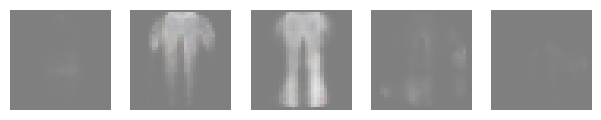

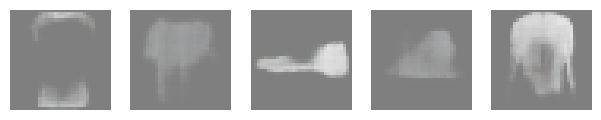

In [10]:
# Corrected function to generate and display images
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 20).to(device)
        samples = model.decode(z).cpu()
        # Corrected reshaping: Adjusting shape for 32x32 with 3 channels as modified Fashion-MNIST
        samples = samples.view(num_images, 3, 32, 32)  # Ensure correct shape for 3-channel images

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 1.5, 3))
    for i, ax in enumerate(axes.flat):
        # Since the images are in three channels and normalized, we can use the normalization mean and std to revert it
        # Normalizing around 0.5 mean (as done during transformation), and showing them as RGB
        img = samples[i].permute(1, 2, 0) * 0.5 + 0.5  # Undo normalization for display
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Assuming you have loaded your trained models and the images correctly
generate_images(fc_vae, num_images=5)
generate_images(cnn_vae, num_images=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


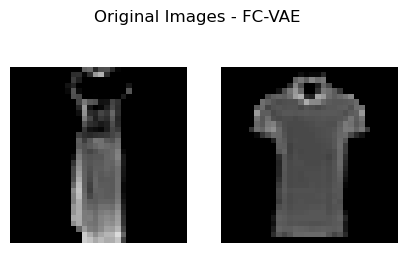

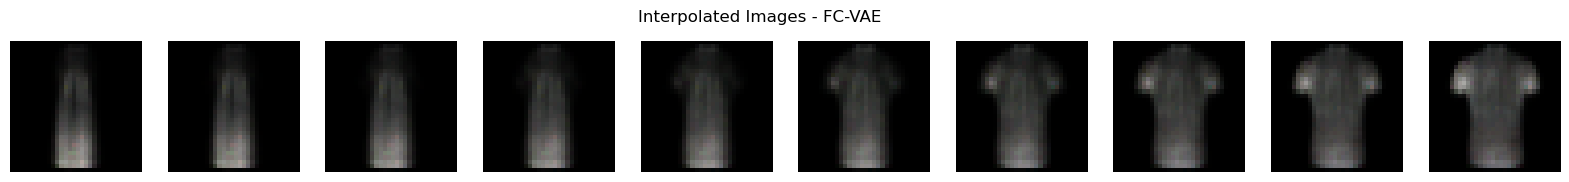

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


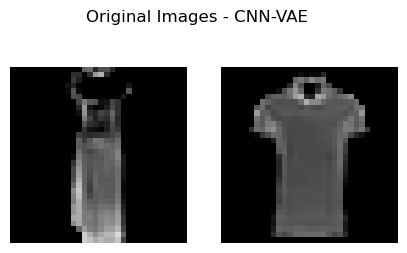

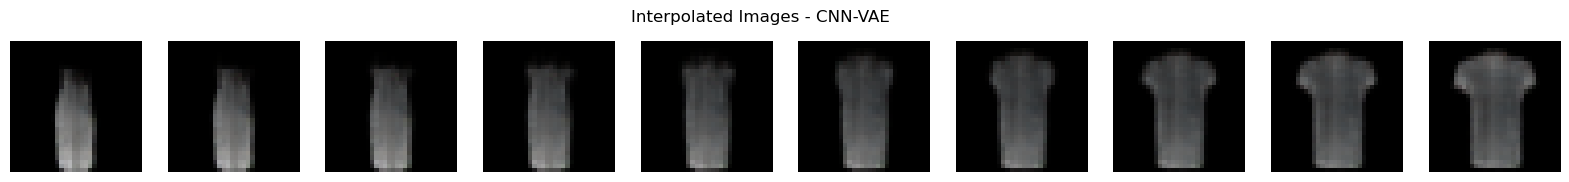

In [11]:
# Cell for Interpolation and Visualization on Fashion-MNIST

def interpolate(model, start_data, end_data, steps=20):
    model.eval()
    with torch.no_grad():
        # Move data to the appropriate device
        start_data = start_data.to(device).unsqueeze(0)
        end_data = end_data.to(device).unsqueeze(0)

        # Encode the start and end images to latent space
        start_mu, start_logvar = model.encode(start_data)
        end_mu, end_logvar = model.encode(end_data)
        
        # Reparameterize to get the latent vectors
        z_start = model.reparameterize(start_mu, start_logvar)
        z_end = model.reparameterize(end_mu, end_logvar)
        
        # Linear interpolation of latent vectors
        interpolation_weights = torch.linspace(0, 1, steps).to(device)
        z_interp = (1 - interpolation_weights)[:, None] * z_start + interpolation_weights[:, None] * z_end
        
        # Decode the interpolated latent vectors
        interp_data = model.decode(z_interp).view(-1, 3, 32, 32)  # Ensure correct shape for 3-channel images

    return interp_data

def display_interpolation(model, images, title):
    images = images.to(device)

    # Select two images for interpolation
    interp_images = interpolate(model, images[0], images[1], steps=10)
    
    # Visualize the actual images
    fig, axs = plt.subplots(1, 2, figsize=(5, 3))
    axs[0].imshow(images[0].cpu().permute(1, 2, 0))
    axs[1].imshow(images[1].cpu().permute(1, 2, 0))
    for ax in axs:
        ax.axis('off')
    plt.suptitle('Original Images - ' + title)
    plt.show()

    # Visualize the interpolated images
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axs):
        ax.imshow(interp_images[i].cpu().detach().permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle('Interpolated Images - ' + title)
    plt.show()

# Get some images
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Display interpolation for FC-VAE
display_interpolation(fc_vae, images[:2], "FC-VAE")

# Display interpolation for CNN-VAE
display_interpolation(cnn_vae, images[:2], "CNN-VAE")
